In [375]:
#载入所需package
import numpy as np
import torch
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mping 
import cmath
from torch import nn
import random
from torch.utils import data
import copy
from scipy.special import kv
from scipy import integrate
import seaborn as sns
import matplotlib as mpl

## Original Generator(para to specific-frequency)

In [376]:
#标准 generator
class generator_t:
    def __init__(self,df,mu = 0, sigma = 1,samplesize = 1000, h = 0.01):
        self.df = df
        self.mu = mu
        self.sigma = sigma
        self.samplesize = samplesize
        self.frequency = h
    @staticmethod
    def cumulate(delta):
        data = torch.zeros(np.shape(delta))
        n = np.shape(delta)[0]
        for i in range(n-1):
            data[i+1] = data[i]+delta[i]
        return np.array(data)
    
    def generate_standard_t(self):
        d0 = np.random.standard_t(self.df, (self.samplesize,1))
        d1 = self.cumulate(d0)
        delta = torch.tensor(d0)
        data = torch.tensor(d1)
        delta.requires_grad_(True)  # 等价于x=torch.arange(4.0,requires_grad=True)
        return delta,data

In [377]:
class Characteristic_function:
    def __init__(self,data):
        self.data = data   
    def ecf(self,t):
        n = len(self.data)
        if type(t)== int:
            C = torch.zeros((n,1))
            S = torch.zeros((n,1))
            for i in range(n):
                C[i] = math.cos(t*self.data[i])
                S[i] = math.sin(t*self.data[i])
            s = torch.mean(S)
            c = torch.mean(C)
            return c,s                
        else:    
            m = len(t)
            R = []
            for j in range(m):
                S = []
                C = []
                for i in range(n):
                    C = C+[math.cos(t[j]*self.data[i])]
                    S = S+[math.sin(t[j]*self.data[i])]
                #S = torch.tensor(S,dtype = torch.float64)
                #C = torch.tensor(C,dtype = torch.float64)
                s = sum(S)/len(S)
                c = sum(C)/len(C)
                R = R+[c]
                R = R+[s]
            #R = torch.tensor(R,dtype = torch.float64)
        return R
    def ecf_h(self,t):
        n = len(self.data)
        if type(t)== int:
            C = torch.zeros((n,1))
            S = torch.zeros((n,1))
            for i in range(n):
                C[i] = math.cos(t*self.data[i])
                S[i] = math.sin(t*self.data[i])
            s = torch.mean(S)
            c = torch.mean(C)
            return c,s                
        else:    
            m = len(t)
            R = []
            for j in range(m):
                S = []
                C = []
                for i in range(n):
                    C = C+[math.cos(t[j]*self.data[i])]
                    S = S+[math.sin(t[j]*self.data[i])]
                #S = torch.tensor(S,dtype = torch.float64)
                #C = torch.tensor(C,dtype = torch.float64)
                s = sum(S)/len(S)
                c = sum(C)/len(C)
                r = (math.sqrt(s**2+c**2))**h
                theta = math.atan(s/c)*h
                c_h = r*math.cos(theta)
                s_h = r*math.sin(theta)
                R = R+[c_h]
                R = R+[s_h]
            #R = torch.tensor(R,dtype = torch.float64)
        return R
    

In [378]:
class rejection_method:    
    def __init__(self,h,n,v,mu = 0,sigma = 1):        
        self.h = h
        self.v = v
        self.mu = mu
        self.sigma = sigma
        self.n = n
    def phi_h(self,t):
        phi_real = math.cos(t*self.mu)*((math.sqrt(self.v)*self.sigma*abs(t))**(self.v/2))/(2**(self.v/2-1)*math.gamma(self.v/2))*kv(self.v/2,math.sqrt(self.v)*self.sigma*abs(t))
        phi_imag = math.sin(t*self.mu)*((math.sqrt(self.v)*self.sigma*abs(t))**(self.v/2))/(2**(self.v/2-1)*math.gamma(self.v/2))*kv(self.v/2,math.sqrt(self.v)*self.sigma*abs(t))
        r = (math.sqrt(phi_real**2+phi_imag**2))**self.h
        theta = math.atan(phi_imag/phi_real)*self.h
        phi_real = r*math.cos(theta)
        phi_imag = r*math.sin(theta)
        phi_abs = math.sqrt(phi_real**2+phi_imag**2)
        return phi_real, phi_imag, phi_abs
    def f(self,x,t_lim=200,t_num=2000):
        t = torch.linspace(-int(t_lim),int(t_lim),t_num)
        intg = []
        #因为密度是real的
        for i in range(t_num):
            r = self.phi_h(t[i])[0]
            im = self.phi_h(t[i])[1]
            intg += [math.cos(t[i]*x)*r+math.sin(t[i]*x)*im]
        y = 1/(2*math.pi)*integrate.trapz(intg, t)
        return y
    def phi_abs0(self,t):
        return self.phi_h(t)[2]
    def phi_prime(self,t,delt = 0.01):
        d_1 = (self.phi_h(t)[0]-self.phi_h(t+delt)[0])/delt
        d_2 = (self.phi_h(t)[1]-self.phi_h(t+delt)[1])/delt
        d_abs = math.sqrt(d_1**2+d_2**2)
        return d_1,d_2
    def phi_prime_prime(self,t,delt = 0.01):
        d_1 = (self.phi_prime(t)[0]-self.phi_prime(t+delt)[0])/delt
        d_2 = (self.phi_prime(t)[1]-self.phi_prime(t+delt)[1])/delt
        d_abs = math.sqrt(d_1**2+d_2**2)
        return d_1,d_2,d_abs  
    def phi_abs2(self,t):
        return self.phi_prime_prime(t)[2]
    def integ(self,domain = 100,ndots = 500):
        t = torch.linspace(-int(domain),int(domain),ndots)
        intg_0 = []
        intg_2 = []
        for i in range(len(t)):
            intg_0 += [self.phi_abs0(t[i])]
        c = 1/(2*math.pi)*integrate.trapz(intg_0, t)
        for i in range(len(t)):
            intg_2 += [self.phi_abs2(t[i])]
        k = 1/(2*math.pi)*integrate.trapz(intg_2, t)
        return c,k
    def hat_function(self,x):        
        c,k = self.integ()
        g = min(c,k/(x**2))
        return g

    def genertator(self):
        total = 25*self.n
        V_1 = np.random.uniform(-1,1,total)
        V_2 = np.random.uniform(-1,1,total)
        c,k = self.integ()
        X = []
        for i in range(total):
            y = math.sqrt(k/c)*(V_1[i]/V_2[i])
            U = np.random.uniform(-1,1)            
            if len(X) >=self.n:
                break
                
            elif U<= (self.f(y)/self.hat_function(y)):
                X+=[y]
            else:
                continue
        return X
        
    @staticmethod
    def cumulate(delta):
        data = torch.zeros(np.shape(delta))
        n = np.shape(delta)[0]
        for i in range(n-1):
            data[i+1] = data[i]+delta[i]
        return np.array(data)    

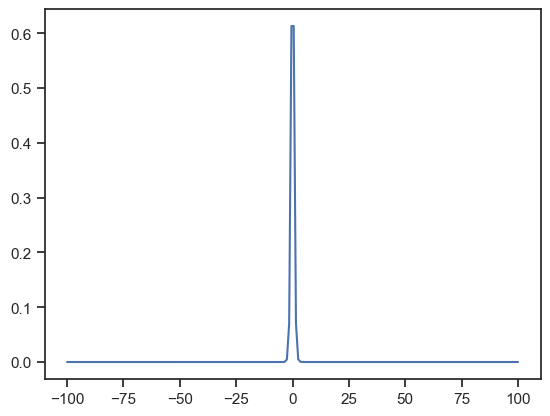

In [379]:
rm = rejection_method(h = 2,n = 1000,v =3)
num_t = 200
range_t = 100
t = torch.linspace(-range_t,range_t,num_t,dtype = torch.float64)
intg_0 = []
for i in range(len(t)):
    intg_0 += [rm.phi_abs0(t[i])]
plt.plot(t,intg_0)

In [380]:
x = rm.genertator()


In [381]:
X = torch.tensor(x)
x_show = []
for i in range(len(x)):
    if abs(x[i])<7:
        x_show+=[x[i]]
len(x_show)

939

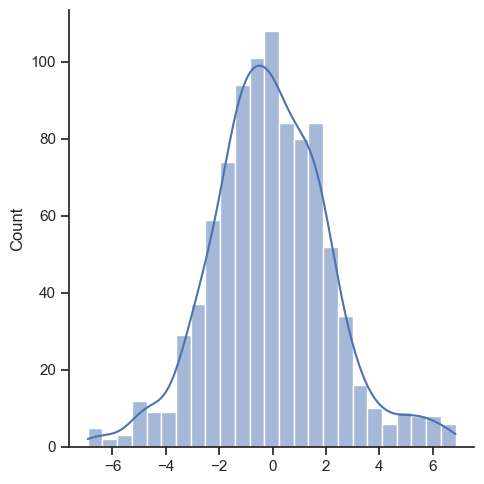

In [382]:
fig = sns.displot(data = x_show,kind = 'hist',kde = "TRUE")


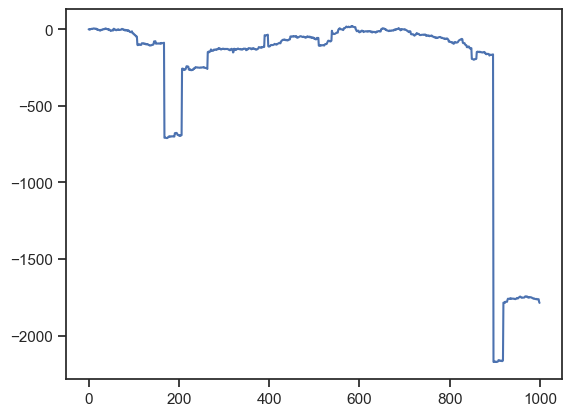

In [293]:
path = rm.cumulate(x)
plt.plot(path)

## frequency changing 

In [294]:
class Characteristic_function:
    def __init__(self,data):
        self.data = data   
    def ecf(self,t):
        n = len(self.data)
        if type(t)== int:
            C = torch.zeros((n,1))
            S = torch.zeros((n,1))
            for i in range(n):
                C[i] = math.cos(t*self.data[i])
                S[i] = math.sin(t*self.data[i])
            s = torch.mean(S)
            c = torch.mean(C)
            return c,s                
        else:    
            m = len(t)
            R = []
            for j in range(m):
                S = []
                C = []
                for i in range(n):
                    C = C+[math.cos(t[j]*self.data[i])]
                    S = S+[math.sin(t[j]*self.data[i])]
                #S = torch.tensor(S,dtype = torch.float64)
                #C = torch.tensor(C,dtype = torch.float64)
                s = sum(S)/len(S)
                c = sum(C)/len(C)
                R = R+[c]
                R = R+[s]
            #R = torch.tensor(R,dtype = torch.float64)
        return R
    def ecf_h(self,t,h):
        n = len(self.data)
        if type(t)== int:
            C = torch.zeros((n,1))
            S = torch.zeros((n,1))
            for i in range(n):
                C[i] = math.cos(t*self.data[i])
                S[i] = math.sin(t*self.data[i])
            s = torch.mean(S)
            c = torch.mean(C)
            r = math.sqrt(s**2+c**2)**h
            theta = math.atan(s/c)*h
            s = math.sin(theta)*r
            c = math.cos(theta)*r
            return c,s                
        else:    
            m = len(t)
            R = []
            for j in range(m):
                S = []
                C = []
                for i in range(n):
                    C = C+[math.cos(t[j]*self.data[i])]
                    S = S+[math.sin(t[j]*self.data[i])]
                #S = torch.tensor(S,dtype = torch.float64)
                #C = torch.tensor(C,dtype = torch.float64)
                s = sum(S)/len(S)
                c = sum(C)/len(C)
                r = math.sqrt(s**2+c**2)**h
                theta = math.atan(s/c)*h
                s = math.sin(theta)*r
                c = math.cos(theta)*r
                R = R+[c]
                R = R+[s]
            #R = torch.tensor(R,dtype = torch.float64)
        return R


In [372]:
num_feature = 100
range_feature = 20
num_sample = 100
num_labels = num_t
total = num_sample*num_feature
#t = t.reshape((-1,len(t)))
feat = torch.linspace(-range_feature,range_feature,num_feature,dtype = torch.float64)

In [373]:
print(num_feature,range_feature,num_sample,num_labels,total,num_t,range_t)

100 20 100 200 10000 200 100


In [374]:
#实例化(V =3)
CF = Characteristic_function(x)
labels = CF.ecf_h(t,0.01)

ValueError: only one element tensors can be converted to Python scalars

In [307]:
a = []
features = []
label = []
for i in range(num_sample):
    label+=labels
    features+=feat


In [312]:
labels =labels.reshape((-1,2*num_labels))
features = torch.tensor(features,dtype = torch.float64).reshape((-1,num_feature))

/var/folders/ym/35040q6j5x912qskn704_hy80000gn/T/ipykernel_26788/2715700207.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features,dtype = torch.float64).reshape((-1,num_feature))


In [342]:
labels.shape

torch.Size([10, 400])

In [313]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)
batch_size = 1
D_loader = load_array((features,labels), batch_size)

In [348]:
next(iter(D_loader))[1].shape

torch.Size([1, 400])

In [315]:
# 初始化参数定义


hidden_2, hidden_3 = 256, 256

W1 = nn.Parameter(torch.randn(
    num_feature, hidden_2, requires_grad=True,dtype = torch.float64) * 0.01)
b1 = nn.Parameter(torch.zeros(hidden_2, requires_grad=True,dtype = torch.float64))

W2 = nn.Parameter(torch.randn(
    hidden_2, hidden_3, requires_grad=True,dtype = torch.float64) * 0.01)
b2 = nn.Parameter(torch.zeros(hidden_3, requires_grad=True,dtype = torch.float64))

W3 = nn.Parameter(torch.randn(
    hidden_3, num_feature, requires_grad=True,dtype = torch.float64) * 0.01)
b3 = nn.Parameter(torch.zeros(num_feature, requires_grad=True,dtype = torch.float64))


params = [W1, b1, W2, b2, W3, b3]

In [316]:
#激活函数
def relu(X):
    a = torch.zeros_like(X)
    b = torch.max(X, a)
    return torch.tensor(b,dtype = torch.float64)

In [363]:
def expcostx(x,V):
    a = t.reshape((-1,1))@x.reshape((1,-1))
    b = (torch.cos(a)-1)@V.reshape((-1,1))
    c = torch.exp((range_feature*2/num_feature)*b)
    return c
def I(x):
    y = copy.deepcopy(x)
    y[abs(x)>1]=0
    return y
    
def realtx(x,V):
    #x = torch.tensor(x,dtype = torch.float64)
    a1 = torch.sin(t.reshape((-1,1))@x.reshape((1,-1))) 
    a2 = t.reshape((-1,1))@I(x).reshape((1,-1))
    a3 = a1+a2
    a4 = a3@V.reshape((-1,1))
    a5 = (range_feature*2/num_feature)*a4
    a6 = torch.cos(a5)
    return a6
def imagetx(x,V):
    #x = torch.tensor(x,dtype = torch.float64)
    a1 = torch.sin(t.reshape((-1,1))@x.reshape((1,-1))) 
    a2 = t.reshape((-1,1))@I(x).reshape((1,-1))
    a3 = a1+a2
    a4 = a3@V.reshape((-1,1))
    a5 = (range_feature*2/num_feature)*a4
    a6 = torch.sin(a5)
    return a6

In [364]:
net_1(features[0])

/var/folders/ym/35040q6j5x912qskn704_hy80000gn/T/ipykernel_26788/2169779723.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(b,dtype = torch.float64)


tensor([[ 0.1296,  0.1737,  0.1312,  0.1649,  0.1097,  0.1483,  0.0790,  0.1255,
          0.0173,  0.1155, -0.0424,  0.0830, -0.0853,  0.0088, -0.0518, -0.0772,
          0.0265, -0.1102,  0.0969, -0.0932,  0.1506, -0.0694,  0.1956, -0.0638,
          0.2358, -0.0614,  0.2666, -0.0607,  0.2371, -0.0612,  0.2300, -0.0247,
          0.2226,  0.0425,  0.1111,  0.1171,  0.0124,  0.1322, -0.0688,  0.0854,
         -0.0924,  0.0430, -0.1017,  0.0070, -0.0678, -0.0010, -0.0999, -0.0145,
         -0.0957, -0.0400, -0.0884, -0.0888, -0.0569, -0.1430,  0.0487, -0.1797,
          0.1178, -0.1556,  0.1597, -0.0701,  0.1503, -0.0349,  0.1637, -0.0347,
          0.1575, -0.0280,  0.1405, -0.0032,  0.1229,  0.0166,  0.0939,  0.0626,
          0.0367,  0.1011, -0.0492,  0.0823, -0.1409,  0.0314, -0.1165, -0.0498,
         -0.0874, -0.1030, -0.0686, -0.1489, -0.0524, -0.1690, -0.0362, -0.1723,
         -0.0399, -0.1862, -0.0089, -0.1722,  0.0561, -0.1420,  0.1156, -0.0974,
          0.1218,  0.0083,  

In [365]:
features[0].shape

torch.Size([100])

In [366]:
def net_1(X):
    X_clone = X.clone()
    X = X.reshape((-1, num_feature))
    H1 = relu(X@W1 + b1)  # 这里“@”代表矩阵乘法
    H2 = relu(H1@W2 + b2)
    V = (H2@W3 + b3)
    R_1 = expcostx(X,V)*realtx(x,V)
    R_2 = expcostx(X,V)*imagetx(x,V)
    R = torch.cat((R_1,R_2),1).reshape((1,-1))
    return R


In [367]:
H0 =  features[0].reshape((-1, num_feature))
H1 = relu(H0@W1 + b1)
H2 = relu(H1@W2 + b2)
V = (H2@W3 + b3)
a = t.reshape((-1,1))@features[0].reshape((-1,num_feature))

/var/folders/ym/35040q6j5x912qskn704_hy80000gn/T/ipykernel_26788/2169779723.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(b,dtype = torch.float64)


In [368]:
loss = nn.MSELoss()

In [369]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [370]:
lr = 0.02
num_epochs = int(num_sample/batch_size)
net = net_1
loss = nn.MSELoss()

trainer = torch.optim.SGD(params, lr=0.03)

In [371]:
for epoch in range(num_epochs):
    for X, y in D_loader:
        l = loss(net_1(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(X), y)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.443206
epoch 2, loss 0.438450
epoch 3, loss 0.432510
epoch 4, loss 0.505179
epoch 5, loss 0.478185
epoch 6, loss 0.448303
epoch 7, loss 0.448179
epoch 8, loss 0.445767
epoch 9, loss 0.442444
epoch 10, loss 0.438674


/var/folders/ym/35040q6j5x912qskn704_hy80000gn/T/ipykernel_26788/2169779723.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(b,dtype = torch.float64)


## visualized characteristic function(real)

ValueError: x and y must have same first dimension, but have shapes torch.Size([200]) and torch.Size([50])

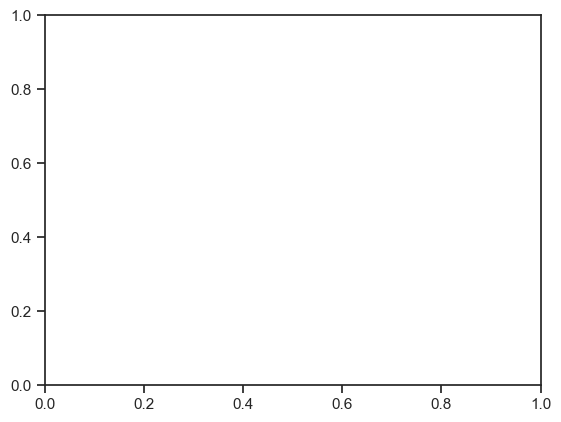

In [362]:
real = torch.zeros(int(len(labels[0])/2)+1)
image = torch.zeros(int(len(labels[0])/2)+1)
for i in range(len(labels[0])):
    if i%2 ==0:
        real[int(i/2)] = labels[0][i]
    else:
        image[int((i+1)/2)] = labels[0][i]
real = real[0:50]
plt.plot(t,real)